# ReadMe

Unless explicitly specified, the basic units in this notebook are constructed from um, fs and keV without other constant.

In [1]:
import sys
sys.path.append("../../../XRaySimulation")

import numpy as np
import matplotlib.pyplot as plt

from XRaySimulation import util, misc, Crystal, GetCrystalParam

 ![](Example1.png)

# Specify the crystal 

In [2]:
E0 = 9.83 #kev
waveVecNum = 100000  # The number of wave vector to calculate 
energyRange = 0.002 #keV.  The energy to calculate the reflectivity

In [14]:
crystalProperties = GetCrystalParam.getCrystalParam(CrystalType="Diamond", MillerIndex="111", EnergyKeV=E0)
                    

# Initialize the crystal
myCrystals = Crystal.CrystalBlock3D(h=np.array([0.0, np.pi * 2 / crystalProperties['d'], 0.0]),
                                     normal=np.array([0., - 1.0, 0.0]),
                                     surface_point=np.zeros(3),
                                     thickness=100,  # um
                                     chi_dict={"chi0": crystalProperties['chi0'],
                                               "chih_sigma": crystalProperties['chi_s'],
                                               "chihbar_sigma": crystalProperties['chi_s'],
                                               "chih_pi": crystalProperties['chi_s'],
                                               "chihbar_pi": crystalProperties['chi_p'],})

# Specify incident wave vectors

In [15]:
# Convert the energy to the wave vector
waveVec0 = np.array([0,0, util.kev_to_wavevec_length(E0)])

# Get the wave vector array and other axes info
kInGrid, axisInfo = util.get_k_mesh_1d(number = waveVecNum, energy_range = energyRange)

# Add the reference wave vector to the wave vector
kInGrid += waveVec0[np.newaxis, :]

# Define the bragg angle to rotate the wave vector array
bragg = util.get_bragg_angle(wave_length = np.pi * 2 / util.kev_to_wavevec_length(energy=E0),
                             plane_distance = crystalProperties['d'])
print("The bragg angle is {:.2f} degree".format(np.rad2deg(bragg)))

# Ajust the Bragg angle a bit
"""
This is just used to shift the rocking curve to the center.
This is not necessary.
"""
#bragg += 1e-6

# Get the rotation matrix for the rotation
rotMat = util.rot_mat_in_yz_plane(theta= bragg)

# Rotate the wave vectors
kInGrid = np.dot(kInGrid, rotMat.T)

The bragg angle is 17.83 degree


# Get the reflectivity

In [16]:
#########################################################################
(reflect_sigma, 
 reflect_pi,
 b,
 kout_grid) = util.get_bragg_reflection_array(kin_grid = kInGrid,
                                         d = myCrystals.thickness,
                                         h = myCrystals.h,
                                         n = myCrystals.normal,
                                         chi0 = myCrystals.chi0,
                                         chih_sigma = myCrystals.chih_sigma,
                                         chihbar_sigma = myCrystals.chihbar_sigma,
                                         chih_pi = myCrystals.chih_pi,
                                         chihbar_pi = myCrystals.chihbar_pi)
print("Finish calculating the reflectivity")

#########################################################################
sigma_reflectivity = np.abs(np.square(reflect_sigma)) / np.abs(b)
#pi_reflectivity = np.abs(np.square(reflect_pi)) / np.abs(b)

Finish calculating the reflectivity


# Show curves

In [17]:
 plt.rcParams["font.family"] = "Times New Roman"

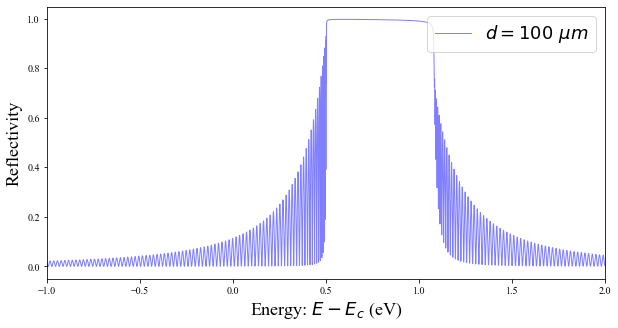

In [18]:
fontsize=18

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(10)

axes.plot(axisInfo['energy_grid'] * 1000, sigma_reflectivity,c='b', linewidth=1, alpha=0.5,label="$d=100~\mu m$")

axes.legend(loc = "upper right", fontsize=fontsize)
axes.set_xlabel("Energy: $E-E_c$ (eV)", fontsize=fontsize)
axes.set_ylabel("Reflectivity", fontsize=fontsize)
axes.set_xlim([-1,2])
#axes.set_xticklabels(labels=np.linspace(-2.5, 2, 10, endpoint=True,), fontsize=fontsize)
#axes.set_yticks(np.linspace(0, 1, 5, endpoint=True,))
#axes.set_yticklabels(labels=np.linspace(0, 1, 5, endpoint=True,), fontsize=fontsize)

#plt.savefig("C:/Users/haoyuan/Desktop/reflectivity_vs_thickness.png",
#            dpi=600,
#            bbox_inches='tight', 
#            pad_inches=0.0,)
plt.show()

# Get Bandwidth

In [19]:
fwhm_sigma = misc.get_fwhm(coordinate=axisInfo["energy_grid"],
                           curve_values=sigma_reflectivity)

print("The fwhm of the reflectivity curver of the sigma polarization of infinitely thick crystal is")
print("{:.2e} eV".format(fwhm_sigma * 1000))

The fwhm of the reflectivity curver of the sigma polarization of infinitely thick crystal is
7.32e-01 eV


# square filter, 30meV

In [20]:
energyRes = axisInfo["energy_grid"][1] - axisInfo["energy_grid"][0]
numReduction = 30 * 1e-6 / energyRes # 30 meV in keV

In [21]:
numReduction

749.9924999997959

In [22]:
waveVecNum / 750

133.33333333333334

In [23]:
refReduced = np.mean(np.reshape(sigma_reflectivity[:133 * 750], (133, 750)), axis=-1)
energyReduced = axisInfo["energy_grid"][:133 * 750:750]

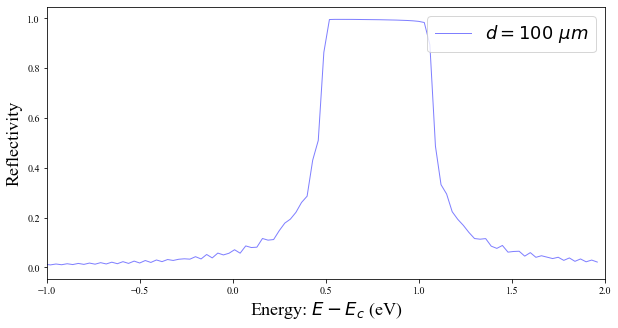

In [24]:
fontsize=18

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(10)

axes.plot(energyReduced * 1000, refReduced,c='b', linewidth=1, alpha=0.5,label="$d=100~\mu m$")

axes.legend(loc = "upper right", fontsize=fontsize)
axes.set_xlabel("Energy: $E-E_c$ (eV)", fontsize=fontsize)
axes.set_ylabel("Reflectivity", fontsize=fontsize)
axes.set_xlim([-1,2])

plt.show()

In [ ]:
np.save("C:/Users/haoyuan/Desktop/energy_keV.npy", axisInfo["energy_grid"])